In [1]:
%load_ext autoreload
%autoreload 2
%run ./initializer

Added the path (/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1) to sys.path


In [2]:
import torch
import torch.nn as nn
import optuna
from sklearn.model_selection import train_test_split
import polars as pl
import pandas as pd

from data_loading import DataPreprocessor
from mood_RNN_classifier import RNNClassifier, MoodDataset, OrdinalLabelSmoothingLoss, split_train_val, objective, train_epoch, evaluate, predict, plot_mood_predictions
from torch.utils.data import DataLoader

/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_loader = DataPreprocessor()
train_df, test_df = data_loader.load_and_preprocess_data("1d")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume train_df and test_df are loaded and preprocessed
id_map = {id_: idx for idx, id_ in enumerate(train_df['id'].unique())}
input_dim = train_df.drop(columns=['id', 'mood', 'date']).shape[1]
id_count = len(id_map)
output_dim = train_df['mood'].max() + 1

train_df_split, val_df_split = split_train_val(train_df, fraction=0.2)

In [5]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, train_df_split, val_df_split, id_map, input_dim, id_count, output_dim, device), n_trials=20)

best_params = study.best_params
print("Best hyperparams:", best_params)

[I 2025-04-17 19:27:26,688] A new study created in memory with name: no-name-0281763f-0edb-41da-8791-c8dd3a8fa8fa
[I 2025-04-17 19:27:27,693] Trial 0 finished with value: 0.5496502667665482 and parameters: {'hidden_dim': 60, 'id_embed_dim': 13, 'lr': 0.0014580731961892637, 'batch_size': 128, 'alpha': 0.11733871865715935}. Best is trial 0 with value: 0.5496502667665482.
[I 2025-04-17 19:27:27,956] Trial 1 finished with value: 0.5442429706454277 and parameters: {'hidden_dim': 101, 'id_embed_dim': 6, 'lr': 0.008764135434220248, 'batch_size': 32, 'alpha': 0.14113416312981794}. Best is trial 1 with value: 0.5442429706454277.
[I 2025-04-17 19:27:28,121] Trial 2 finished with value: 0.6601311415433884 and parameters: {'hidden_dim': 56, 'id_embed_dim': 16, 'lr': 0.003929244798940246, 'batch_size': 64, 'alpha': 0.22633715262114873}. Best is trial 1 with value: 0.5442429706454277.
[I 2025-04-17 19:27:28,258] Trial 3 finished with value: 0.6806659698486328 and parameters: {'hidden_dim': 110, 'id_

Best hyperparams: {'hidden_dim': 91, 'id_embed_dim': 12, 'lr': 0.0025186361026787074, 'batch_size': 64, 'alpha': 0.033178810112166335}


In [6]:
# Final model
model = RNNClassifier(
    input_dim=input_dim,
    hidden_dim=best_params['hidden_dim'],
    id_count=id_count,
    id_embed_dim=best_params['id_embed_dim'],
    output_dim=output_dim
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = OrdinalLabelSmoothingLoss(num_classes=output_dim, alpha=best_params['alpha'])

train_loader = DataLoader(MoodDataset(train_df_split, id_map), batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(MoodDataset(val_df_split, id_map), batch_size=best_params['batch_size'])

In [7]:
for epoch in range(20):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}: train loss = {train_loss:.4f}, val loss = {val_loss:.4f}")

Epoch 1: train loss = 0.7996, val loss = 0.5973
Epoch 2: train loss = 0.4174, val loss = 0.2898
Epoch 3: train loss = 0.2325, val loss = 0.2106
Epoch 4: train loss = 0.1869, val loss = 0.1917
Epoch 5: train loss = 0.1711, val loss = 0.1800
Epoch 6: train loss = 0.1633, val loss = 0.1749
Epoch 7: train loss = 0.1584, val loss = 0.1707
Epoch 8: train loss = 0.1545, val loss = 0.1709
Epoch 9: train loss = 0.1530, val loss = 0.1732
Epoch 10: train loss = 0.1516, val loss = 0.1672
Epoch 11: train loss = 0.1471, val loss = 0.1688
Epoch 12: train loss = 0.1448, val loss = 0.1657
Epoch 13: train loss = 0.1426, val loss = 0.1667
Epoch 14: train loss = 0.1403, val loss = 0.1673
Epoch 15: train loss = 0.1393, val loss = 0.1661
Epoch 16: train loss = 0.1376, val loss = 0.1632
Epoch 17: train loss = 0.1357, val loss = 0.1678
Epoch 18: train loss = 0.1363, val loss = 0.1668
Epoch 19: train loss = 0.1366, val loss = 0.1651
Epoch 20: train loss = 0.1331, val loss = 0.1618


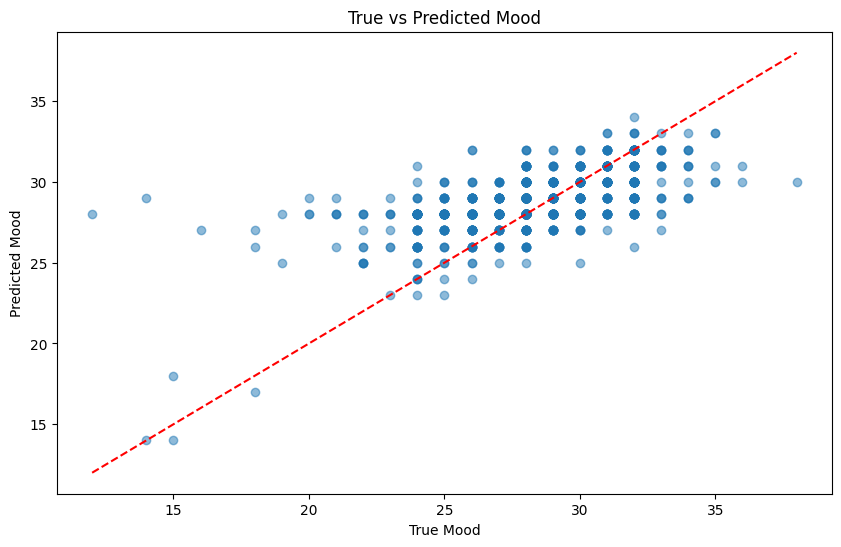

In [8]:
plot_mood_predictions(model, train_loader, device)

In [9]:
# Run predictions on test_df
test_predictions = predict(model, test_df, id_map, device)

# Attach predictions to test_df
test_df_with_preds = test_df.copy()
test_df_with_preds['predicted_mood_class'] = test_predictions

# Optional: save to CSV or examine
print(test_df_with_preds[['id', 'predicted_mood_class']])

         id  predicted_mood_class
0   AS14.01                    29
1   AS14.02                    29
2   AS14.03                    30
3   AS14.05                    28
4   AS14.06                    30
5   AS14.07                    25
6   AS14.08                    28
7   AS14.09                    28
8   AS14.12                    24
9   AS14.13                    32
10  AS14.14                    28
11  AS14.15                    29
12  AS14.16                    29
13  AS14.17                    29
14  AS14.19                    28
15  AS14.20                    29
16  AS14.23                    32
17  AS14.24                    28
18  AS14.25                    28
19  AS14.26                    28
20  AS14.27                    30
21  AS14.28                    28
22  AS14.29                    28
23  AS14.30                    30
24  AS14.31                    28
25  AS14.32                    30
26  AS14.33                    29


In [10]:
train_df['mood'].unique(), train_df['mood'].value_counts()

(array([25, 26, 28, 24, 27, 32, 30, 29, 31, 33, 23, 18, 20, 22, 36, 35, 34,
        15, 21, 14, 19, 16, 12, 38], dtype=int32),
 mood
 28    301
 29    138
 32    128
 30    124
 26    103
 27     98
 31     98
 24     66
 25     65
 33     21
 22     17
 23     17
 34     13
 20      7
 35      6
 21      5
 36      4
 18      3
 14      3
 15      2
 19      2
 16      1
 12      1
 38      1
 Name: count, dtype: int64)